# temp

## 关于夏普比率计算方式的确认

In [212]:
import framework_portfolio_weight_performace as portfolio_weight_performace
import pandas as pd
import numpy as np 

In [213]:
SP500_df = pd.read_excel(r'..\WashedData\SP500indexFromWind.xlsx', index_col=0, header=0)

In [214]:
SP500_return = SP500_df.pct_change().dropna()

<AxesSubplot:xlabel='Date'>

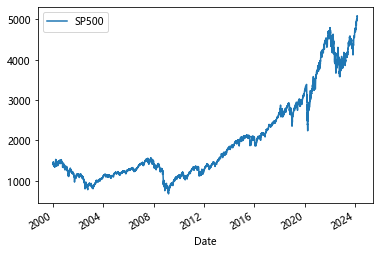

In [215]:
%matplotlib inline
SP500_df.plot()

In [216]:
SP500_df

,SP500
Date,
2000-01-04,1399.42
2000-01-05,1402.11
2000-01-06,1403.45
2000-01-07,1441.47
2000-01-10,1457.60
...,...
2024-02-22,5087.03
2024-02-23,5088.80
2024-02-26,5069.53


In [217]:
SP500_df.iloc[0]['SP500']

1399.42

In [218]:
(SP500_df.iloc[-1]['SP500'] / SP500_df.iloc[0]['SP500']) - 1

2.6225936459390313

In [219]:
len(SP500_df['SP500'])

5852

In [220]:
(1 + ((SP500_df.iloc[-1]['SP500'] / SP500_df.iloc[0]['SP500']) - 1)**(1/len(SP500_df['SP500'])) - 1)**252 - 1

0.042392981711784294

In [93]:
annual_return = ((SP500_df['SP500'][-1] - SP500_df['SP500'][0]) / SP500_df['SP500'][0]) ** (1/24) -1
annual_return

0.04099136052156682

In [94]:
(annual_return - 0.03) / (SP500_df['Returns'].std(ddof=1) * (252**0.5))

0.05579312401096584

In [56]:
SP500_std = SP500_return.std()
annual_std = SP500_std[0] * 250 ** (0.5)
annual_std

0.19621875132114885

In [57]:
sharpe = (annual_return - 0.03) / annual_std
sharpe

0.05601585193852037

In [60]:
# 计算每日收益率
SP500_df['Returns'] = np.log(SP500_df['SP500'] / SP500_df['SP500'].shift(1))

# 初始化一个DataFrame来保存结果
results = pd.DataFrame()

# 按年计算统计量
for year, group in SP500_df.groupby(SP500_df.index.year):
    if year < 2000 or year > 2023:
        continue
    annual_return = np.exp(group['Returns'].sum()) ** (252 / group['Returns'].count()) - 1  # 年化收益率
    annual_volatility = group['Returns'].std() * np.sqrt(252)  # 年化标准差
    sharpe_ratio = (annual_return - 0.03) / annual_volatility  # 夏普比率
    
    results.loc[year, 'Annual Return'] = annual_return
    results.loc[year, 'Annual Volatility'] = annual_volatility
    results.loc[year, 'Sharpe Ratio'] = sharpe_ratio

# 计算整个期间的年化收益率和标准差
total_days = SP500_df['Returns'].count()
total_period_return = np.exp(SP500_df['Returns'].sum()) ** (252 / total_days) - 1
total_period_volatility = SP500_df['Returns'].std() * np.sqrt(252)

# 计算整个期间的夏普比率
total_period_sharpe = (total_period_return - 0.03) / total_period_volatility

results.loc['2000-2023', 'Annual Return'] = total_period_return
results.loc['2000-2023', 'Annual Volatility'] = total_period_volatility
results.loc['2000-2023', 'Sharpe Ratio'] = total_period_sharpe

# 打印结果
print(results)

           Annual Return  Annual Volatility  Sharpe Ratio
2000           -0.059777           0.220060     -0.407967
2001           -0.136482           0.215927     -0.771012
2002           -0.246460           0.256789     -1.076603
2003            0.277382           0.176712      1.399918
2004            0.093416           0.108269      0.585728
2005            0.031270           0.109701      0.011572
2006            0.142835           0.101025      1.116906
2007            0.044230           0.163590      0.086986
2008           -0.396371           0.419467     -1.016459
2009            0.243100           0.274266      0.776982
2010            0.133447           0.181935      0.568594
2011           -0.000033           0.237275     -0.126574
2012            0.139353           0.127421      0.858202
2013            0.315931           0.111507      2.564255
2014            0.117345           0.106885      0.817184
2015           -0.007503           0.162748     -0.230438
2016          

In [222]:
def calculate_financial_metrics(df, risk_free_rate=0.03):
    """
    Calculate annualized return, annualized standard deviation, Sharpe ratio, and maximum drawdown.

    Args:
    df (DataFrame): DataFrame with a 'daily_return' column and datetime index.
    risk_free_rate (float): Annual risk-free rate, default is 3%.

    Returns:
    tuple: (annualized return, annualized standard deviation, Sharpe ratio, maximum drawdown)
    """
    # 确保'daily_return'列存在
    if 'daily_return' not in df.columns:
        raise ValueError("DataFrame must include a 'daily_return' column")

    # 年化收益率
    daily_return = df['daily_return']
    annualized_return = np.prod(1 + daily_return) ** (252 / len(daily_return)) - 1

    # 年化标准差
    annualized_std = daily_return.std() * np.sqrt(252)

    # 夏普比率
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std

    # 最大回撤
    cumulative_returns = (1 + daily_return).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    return annualized_return, annualized_std, sharpe_ratio, max_drawdown

In [223]:
df = SP500_df
# 计算每日百分比收益率
df['Returns'] = (df['SP500'] - df['SP500'].shift(1)) / df['SP500'].shift(1)

# 初始化一个DataFrame来保存结果
results = pd.DataFrame()

# 按年计算统计量
for year, group in df.groupby(df.index.year):
    if year < 2000 or year > 2023:
        continue
    # 计算年化收益率
    annual_return = (1 + group['Returns'].sum()) ** (252 / group['Returns'].count()) - 1
    # 计算年化标准差
    annual_volatility = group['Returns'].std() * np.sqrt(252)
    # 计算夏普比率
    sharpe_ratio = (annual_return - 0.03) / annual_volatility
    
    results.loc[year, 'Annual Return'] = annual_return
    results.loc[year, 'Annual Volatility'] = annual_volatility
    results.loc[year, 'Sharpe Ratio'] = sharpe_ratio

# 计算整个期间的年化收益率和标准差
total_days = df['Returns'].count()
total_period_return = (1 + df['Returns'].sum()) ** (252 / total_days) - 1
total_period_volatility = df['Returns'].std() * np.sqrt(252)

# 计算整个期间的夏普比率
total_period_sharpe = (total_period_return - 0.03) / total_period_volatility

results.loc['2000-2023', 'Annual Return'] = total_period_return
results.loc['2000-2023', 'Annual Volatility'] = total_period_volatility
results.loc['2000-2023', 'Sharpe Ratio'] = total_period_sharpe

# 打印结果
print(results)

           Annual Return  Annual Volatility  Sharpe Ratio
2000           -0.037478           0.220140     -0.306522
2001           -0.123115           0.215884     -0.709244
2002           -0.247940           0.257308     -1.080184
2003            0.261880           0.177049      1.309697
2004            0.095317           0.108251      0.603384
2005            0.036806           0.109540      0.062129
2006            0.139037           0.101134      1.078146
2007            0.056653           0.163244      0.163270
2008           -0.414702           0.417027     -1.066362
2009            0.256169           0.274757      0.823160
2010            0.142158           0.181893      0.616616
2011            0.027969           0.236748     -0.008580
2012            0.138914           0.127531      0.854021
2013            0.282916           0.111490      2.268518
2014            0.116848           0.106794      0.813235
2015            0.005667           0.162920     -0.149358
2016          

分时期, 百分比收益率

In [224]:
# 定义各个子时期
df = SP500_df
periods = {
    'Sub-period 1': ('2001-01-01', '2006-12-31'), # Sideways market
    'Sub-period 2': ('2007-01-01', '2009-12-31'), # Sub-prime mortgage crisis
    'Sub-period 3': ('2010-01-01', '2019-12-31'), # Bull market
    'Sub-period 4': ('2020-01-01', '2020-04-30'), # COVID-19 pandemic crisis
    'Sub-period 5': ('2020-05-01', '2021-08-31') # Bull market
}

# 计算每日收益率
df['Returns'] = df['SP500'].pct_change()

# 初始化一个DataFrame来保存结果
results = pd.DataFrame()

# 计算每个子时期的年化标准差，年化收益率和夏普比率
for period, (start, end) in periods.items():
    sub_df = df.loc[start:end]
    if not sub_df.empty:
        # 年化收益率
        daily_return = sub_df['Returns'].dropna()
        cumulative_return = (1 + daily_return).prod()
        annual_return = cumulative_return ** (252 / len(daily_return)) - 1
        
        # 年化标准差
        annual_volatility = daily_return.std() * (252 ** 0.5)
        
        # 夏普比率
        sharpe_ratio = (annual_return - 0.02) / annual_volatility
        
        results.loc[period, 'Annual Return'] = annual_return
        results.loc[period, 'Annual Volatility'] = annual_volatility
        results.loc[period, 'Sharpe Ratio'] = sharpe_ratio

# 打印结果
results

,Annual Return,Annual Volatility,Sharpe Ratio
Sub-period 1,0.012576,0.171883,-0.043190
Sub-period 2,-0.079465,0.304115,-0.327064
Sub-period 3,0.116582,0.149039,0.648034
Sub-period 4,-0.281726,0.547549,-0.551048
Sub-period 5,0.405247,0.162818,2.366124


按照实际天数, 而非简单的252天年化

In [125]:
results = pd.DataFrame()

# 计算每个子时期的年化标准差，年化收益率和夏普比率
for period, (start, end) in periods.items():
    sub_df = df.loc[start:end]
    if not sub_df.empty:
        # 计算简单收益率
        start_price = sub_df['SP500'].iloc[0]
        end_price = sub_df['SP500'].iloc[-1]
        simple_return = (end_price - start_price) / start_price
        
        # 计算实际天数
        days = (sub_df.index[-1] - sub_df.index[0]).days
        
        # 年化收益率
        annual_return = (1 + simple_return) ** (365 / days) - 1
        
        # 年化标准差
        daily_return = sub_df['SP500'].pct_change().dropna()
        annual_volatility = daily_return.std() * (252 ** 0.5)  # Assuming 252 trading days per year
        
        # 夏普比率
        sharpe_ratio = (annual_return - 0.02) / annual_volatility
        
        results.loc[period, 'Annual Return'] = annual_return
        results.loc[period, 'Annual Volatility'] = annual_volatility
        results.loc[period, 'Sharpe Ratio'] = sharpe_ratio

results

,Annual Return,Annual Volatility,Sharpe Ratio
Sub-period 1,0.016838,0.171539,-0.018435
Sub-period 2,-0.077254,0.304323,-0.319575
Sub-period 3,0.110537,0.148985,0.607692
Sub-period 4,-0.290911,0.550844,-0.564426
Sub-period 5,0.419227,0.161756,2.468086


log-return的版本看起来给的收益率更低

In [110]:
# 定义各个子时期
periods = {
    'Sub-period 1': ('2001-01-01', '2006-12-31'), # Sideways market
    'Sub-period 2': ('2007-01-01', '2009-12-31'), # Sub-prime mortgage crisis
    'Sub-period 3': ('2010-01-01', '2019-12-31'), # Bull market
    'Sub-period 4': ('2020-01-01', '2020-04-30'), # COVID-19 pandemic crisis
    'Sub-period 5': ('2020-05-01', '2021-08-31') # Bull market
}

results = pd.DataFrame()
df['Log Returns'] = np.log(df['SP500'] / df['SP500'].shift(1))

# 计算每个子时期的年化标准差，年化收益率和夏普比率
for period, (start, end) in periods.items():
    sub_df = df.loc[start:end]
    if not sub_df.empty:
        # 计算日对数收益率的平均值，并年化
        mean_log_return = sub_df['Log Returns'].mean()
        annual_return = (mean_log_return * 252)  # 年化收益率
        
        # 计算对数收益率的年化标准差
        annual_volatility = sub_df['Log Returns'].std() * np.sqrt(252)
        
        # 计算夏普比率，假设无风险利率为
        sharpe_ratio = (annual_return - 0.02) / annual_volatility
        
        results.loc[period, 'Annual Return'] = annual_return
        results.loc[period, 'Annual Volatility'] = annual_volatility
        results.loc[period, 'Sharpe Ratio'] = sharpe_ratio

results

,Annual Return,Annual Volatility,Sharpe Ratio
Sub-period 1,0.012498,0.171747,-0.043681
Sub-period 2,-0.082800,0.305251,-0.336772
Sub-period 3,0.110272,0.149212,0.604996
Sub-period 4,-0.330904,0.551537,-0.636229
Sub-period 5,0.340213,0.163426,1.959371


# 年化收益率/夏普比率代码整理

In [180]:
# https://github.com/ranaroussi/quantstats

import io as _io
import datetime as _dt
import pandas as _pd
import numpy as _np
import sys

def to_excess_returns(returns, rf, nperiods=None):
    """
    Calculates excess returns by subtracting
    risk-free returns from total returns

    Args:
        * returns (Series, DataFrame): Returns
        * rf (float, Series, DataFrame): Risk-Free rate(s)
        * nperiods (int): Optional. If provided, will convert rf to different
            frequency using deannualize
    Returns:
        * excess_returns (Series, DataFrame): Returns - rf
    """
    if isinstance(rf, int):
        rf = float(rf)

    if not isinstance(rf, float):
        rf = rf[rf.index.isin(returns.index)]

    if nperiods is not None:
        # deannualize
        rf = _np.power(1 + rf, 1.0 / nperiods) - 1.0

    return returns - rf


def prepare_returns(data, rf=0.0, nperiods=None):
    """Converts price data into returns + cleanup"""
    data = data.copy()
    if isinstance(data, _pd.DataFrame):
        for col in data.columns:
            if data[col].dropna().min() >= 0 and data[col].dropna().max() > 1:
                data[col] = data[col].pct_change()
    elif data.min() >= 0 and data.max() > 1:
        data = data.pct_change()

    # cleanup data
    data = data.replace([_np.inf, -_np.inf], float("NaN"))

    if isinstance(data, (_pd.DataFrame, _pd.Series)):
        data = data.fillna(0).replace([_np.inf, -_np.inf], float("NaN"))
    
    if rf > 0:
        return to_excess_returns(data, rf, nperiods)
        
    return data


def sharpe(returns, rf=0.0, periods=252, annualize=True, smart=False):
    """
    Calculates the sharpe ratio of access returns

    If rf is non-zero, you must specify periods.
    In this case, rf is assumed to be expressed in yearly (annualized) terms

    Args:
        * returns (Series, DataFrame): Input return series
        * rf (float): Risk-free rate expressed as a yearly (annualized) return
        * periods (int): Freq. of returns (252/365 for daily, 12 for monthly)
        * annualize: return annualize sharpe?
        * smart: return smart sharpe ratio
    """
    if rf != 0 and periods is None:
        raise Exception("Must provide periods if rf != 0")

    returns = prepare_returns(returns, rf, periods)
    divisor = returns.std(ddof=1)

    '''if smart:
        # penalize sharpe with auto correlation
        divisor = divisor * autocorr_penalty(returns)'''
    res = returns.mean() / divisor

    if annualize:
        return res * _np.sqrt(1 if periods is None else periods), returns.mean(), divisor

    return res, returns.mean(), divisor


In [138]:
returns_df = df.drop(['SP500','Log Returns'],axis=1).dropna()
returns_df

,Returns
Date,
2000-01-05,0.001922
2000-01-06,0.000956
2000-01-07,0.027090
2000-01-10,0.011190
2000-01-11,-0.013063
...,...
2024-02-22,0.021123
2024-02-23,0.000348
2024-02-26,-0.003787


In [156]:
print(type(returns_df['Returns']))
res = sharpe(returns=returns_df['Returns'], rf=0.02, periods=252, annualize=True, smart=False)
res

<class 'pandas.core.series.Series'>


0.38020757691851503

In [182]:
# 定义各个子时期
periods = {
    'Sub-period 1': ('2001-01-01', '2006-12-31'), # Sideways market
    'Sub-period 2': ('2007-01-01', '2009-12-31'), # Sub-prime mortgage crisis
    'Sub-period 3': ('2010-01-01', '2019-12-31'), # Bull market
    'Sub-period 4': ('2020-01-01', '2020-04-30'), # COVID-19 pandemic crisis
    'Sub-period 5': ('2020-05-01', '2021-08-31') # Bull market
}

results = pd.DataFrame()
df['Log Returns'] = np.log(df['SP500'] / df['SP500'].shift(1))

# 计算每个子时期的年化标准差，年化收益率和夏普比率
for period, (start, end) in periods.items():
    sub_df = df.loc[start:end]
    if not sub_df.empty:
        sharpe_ratio, annual_return, annual_volatility = sharpe(returns=sub_df['Returns'], rf=0.02, periods=252, annualize=True, smart=False)
        
        results.loc[period, 'Annual Return'] = annual_return * np.sqrt(252)
        results.loc[period, 'Annual Volatility'] = annual_volatility * np.sqrt(252)
        results.loc[period, 'Sharpe Ratio'] = sharpe_ratio

results

,Annual Return,Annual Volatility,Sharpe Ratio
Sub-period 1,0.000469,0.171883,0.043286
Sub-period 2,-0.003541,0.304115,-0.184814
Sub-period 3,0.006401,0.149039,0.681788
Sub-period 4,-0.012674,0.547549,-0.367454
Sub-period 5,0.021035,0.162818,2.050910


# 关于回测结果的检查

In [185]:
import os
import pandas as pd
from tqdm import tqdm

# 设定文件夹路径
folder_path = 'multi_backtest_result'
files = [f for f in os.listdir(folder_path) if f.startswith('weights') and f.endswith('.xlsx')]

# 初始化一个列表，用于存储所有文件的数据
data_list = []

# 遍历文件夹中的文件
for filename in tqdm(files):
    # 解析文件名以获取参数
    parts = filename.split('_')
    k = parts[2][1:]  # 资产数量 'k10' -> '10'
    window = parts[3][6:]  # 时间窗口 'window30' -> '30'
    type_algo = parts[4][4:-5]  # 选股算法类型 'typeFC' -> 'FC'

    # 构建完整的文件路径
    file_path = os.path.join(folder_path, filename)

    # 读取 'Daily_Return_HRP' 工作表
    df = pd.read_excel(file_path, sheet_name='Daily_Return_HRP', skiprows=1, usecols='A:B')
    df.columns = ['date', 'daily_return']
    df.set_index('date', inplace=True)

    # 将解析的参数和数据存储
    data_list.append({
        'k': k,
        'window': window,
        'type': type_algo,
        'data': df
    })


100%|██████████| 72/72 [08:47<00:00,  7.33s/it]


In [186]:
# 打印读取的结果，等待进一步处理
for data in data_list:
    print(f"Data for k={data['k']}, window={data['window']}, type={data['type']}")
    print(data['data'].head())  # 打印每个文件的前几行数据，进行检查

Data for k=100, window=100, type=FC
            daily_return
date                    
2000-06-15      0.001201
2000-06-16     -0.006433
2000-06-19      0.003580
2000-06-20     -0.004165
2000-06-21     -0.000727
Data for k=100, window=100, type=GMSC
            daily_return
date                    
2000-06-15      0.003733
2000-06-16     -0.008360
2000-06-19      0.006318
2000-06-20     -0.010603
2000-06-21      0.003033
Data for k=100, window=200, type=FC
            daily_return
date                    
2000-11-09     -0.007641
2000-11-10     -0.011798
2000-11-13      0.001949
2000-11-14      0.008410
2000-11-15      0.008883
Data for k=100, window=200, type=GMSC
            daily_return
date                    
2000-11-09     -0.005388
2000-11-10     -0.009567
2000-11-13      0.000075
2000-11-14      0.008411
2000-11-15      0.011646
Data for k=100, window=300, type=FC
            daily_return
date                    
2001-04-13      0.000000
2001-04-16     -0.000711
2001-04-17      

In [188]:
import pandas as pd
import numpy as np

def calculate_financial_metrics(df, risk_free_rate=0.03):
    """
    Calculate annualized return, annualized standard deviation, Sharpe ratio, and maximum drawdown.

    Args:
    df (DataFrame): DataFrame with a 'daily_return' column and datetime index.
    risk_free_rate (float): Annual risk-free rate, default is 3%.

    Returns:
    tuple: (annualized return, annualized standard deviation, Sharpe ratio, maximum drawdown)
    """
    # 确保'daily_return'列存在
    if 'daily_return' not in df.columns:
        raise ValueError("DataFrame must include a 'daily_return' column")

    # 年化收益率
    daily_return = df['daily_return']
    annualized_return = np.prod(1 + daily_return) ** (252 / len(daily_return)) - 1

    # 年化标准差
    annualized_std = daily_return.std() * np.sqrt(252)

    # 夏普比率
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std

    # 最大回撤
    cumulative_returns = (1 + daily_return).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    return annualized_return, annualized_std, sharpe_ratio, max_drawdown

In [208]:
df = pd.DataFrame(data_list)
df

,k,window,type,data
0,100,100,FC,daily_return date ...
1,100,100,GMSC,daily_return date ...
2,100,200,FC,daily_return date ...
3,100,200,GMSC,daily_return date ...
4,100,300,FC,daily_return date ...
...,...,...,...,...
67,50,30,GMSC,daily_return date ...
68,50,500,FC,daily_return date ...
69,50,500,GMSC,daily_return date ...
70,50,50,FC,daily_return date ...


In [209]:
# 定义时期
periods = {
    'p-1': ('2001-01-01', '2006-12-31'),
    'p-2': ('2007-01-01', '2009-12-31'),
    'p-3': ('2010-01-01', '2019-12-31'),
    'p-4': ('2020-01-01', '2020-04-30'),
    'p-5': ('2020-05-01', '2021-08-31')
}

# 遍历每个时期
for period_name, (start_date, end_date) in periods.items():
    # 新列名
    col_names = [f"{period_name} {metric}" for metric in ["an~return", "an~std", "sharpe", "max~draw"]]
    
    # 计算每个时期的指标
    for idx, row in df.iterrows():
        # 提取特定时期的数据
        period_data = row['data'].loc[start_date:end_date]
        # 调用之前定义的函数计算金融指标
        if not period_data.empty:
            results = calculate_financial_metrics(period_data)
            # 将结果添加到DataFrame中
            df.loc[idx, col_names[0]] = results[0]  # Annual Return
            df.loc[idx, col_names[1]] = results[1]  # Annual Standard Deviation
            df.loc[idx, col_names[2]] = results[2]  # Sharpe Ratio
            df.loc[idx, col_names[3]] = results[3]  # Max Drawdown
        else:
            # 如果时期内没有数据，填充NaN
            df.loc[idx, col_names] = [np.nan] * 4


In [210]:
df

,k,window,type,data,p-1 an~return,p-1 an~std,p-1 sharpe,p-1 max~draw,p-2 an~return,p-2 an~std,...,p-3 sharpe,p-3 max~draw,p-4 an~return,p-4 an~std,p-4 sharpe,p-4 max~draw,p-5 an~return,p-5 an~std,p-5 sharpe,p-5 max~draw
0,100,100,FC,daily_return date ...,0.085415,0.127828,0.433510,-0.249138,-0.027904,0.245526,...,0.603902,-0.179233,-0.321185,0.520861,-0.674241,-0.351571,0.375583,0.148892,2.321030,-0.084288
1,100,100,GMSC,daily_return date ...,0.090427,0.132665,0.455486,-0.249454,-0.023940,0.244025,...,0.688718,-0.176350,-0.217656,0.519163,-0.477029,-0.327830,0.319300,0.144295,2.004927,-0.072200
2,100,200,FC,daily_return date ...,0.091280,0.134255,0.456447,-0.257579,-0.004780,0.243976,...,0.657139,-0.175279,-0.267418,0.514830,-0.577701,-0.330487,0.321398,0.143615,2.029021,-0.074786
3,100,200,GMSC,daily_return date ...,0.090124,0.130614,0.460317,-0.250606,-0.017285,0.242989,...,0.720740,-0.168454,-0.258538,0.519549,-0.555363,-0.327861,0.296771,0.141479,1.885595,-0.068735
4,100,300,FC,daily_return date ...,0.113123,0.132383,0.627894,-0.239983,-0.017633,0.250788,...,0.669862,-0.190796,-0.303379,0.542166,-0.614902,-0.352794,0.396675,0.153565,2.387745,-0.078170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,50,30,GMSC,daily_return date ...,0.062677,0.130227,0.250920,-0.235871,-0.020410,0.250590,...,0.706113,-0.204459,-0.302000,0.536709,-0.618585,-0.357614,0.362526,0.143888,2.311011,-0.076654
68,50,500,FC,daily_return date ...,0.106929,0.141855,0.542308,-0.260196,-0.020305,0.244888,...,0.777123,-0.186067,-0.183850,0.529912,-0.403557,-0.319820,0.333361,0.147370,2.058492,-0.075120
69,50,500,GMSC,daily_return date ...,0.122729,0.138715,0.668488,-0.285215,-0.015876,0.253124,...,0.731319,-0.205427,-0.220049,0.509052,-0.491205,-0.317886,0.278844,0.143335,1.736102,-0.077379
70,50,50,FC,daily_return date ...,0.061377,0.133292,0.235398,-0.243455,-0.026924,0.235281,...,0.762757,-0.156362,-0.266532,0.517005,-0.573558,-0.325661,0.341913,0.144561,2.157654,-0.070303


In [211]:
df.to_csv('all_result.csv')